## Synthetic Data Generation Curriculum

This notebook contains a comprehensive curriculum on generating synthetic data from seed prompts, following the methodology used in the [Cosmopedia](https://huggingface.co/datasets/HuggingFaceTB/cosmopedia) project:

1. **Seed Prompt Preparation**

   - Load seed text samples from reference sources
   - Tokenize and preprocess text
   - Filter samples for educational quality
   - Cluster similar content to identify unique topics

2. **Prompt Engineering**

   - Design template prompts for different styles (textbook, blog, wikihow)
   - Insert seed content into templates using pattern replacement
   - Add contextual elements (topics, audience targeting)
   - Set extraction size limits for seed content inclusion

3. **Generation Configuration**

   - Configure model parameters (temperature, top_p, max_tokens)
   - Set up generation environment (hardware, tokenizer, model)
   - Create checkpoint directories for saving outputs
   - Initialize monitoring tools for tracking generation metrics

4. **Content Generation**

   - Implement batch processing for efficient generation
   - Apply asynchronous request handling with retry logic
   - Track token usage and generation throughput
   - Save checkpoints at regular intervals to prevent data loss

5. **Post-Processing**

   - Clean generated text by removing boilerplate content
   - Apply deduplication to eliminate redundant content
   - Filter generations by minimum token length
   - Format outputs consistently for downstream use

6. **Quality Assessment**
   - Verify educational value of generated content
   - Analyze topic distribution for comprehensive coverage
   - Ensure content adheres to intended style/format
   - Validate output consistency across batches


# Synthetic Data Generation from Seed Prompts

This notebook provides a comprehensive curriculum for generating high-quality synthetic data from seed prompts based on the [Cosmopedia](https://github.com/huggingface/cosmopedia) methodology. The curriculum covers the entire pipeline from seed prompt preparation to quality assessment of generated content.

> **Cosmopedia** is a dataset of synthetic textbooks, blogposts, stories, posts and WikiHow articles generated by Mixtral-8x7B-Instruct-v0.1. It contains over 30 million files and 25 billion tokens, making it the largest open synthetic dataset to date.


## Setting up the Environment


In [1]:
# Install required libraries
!uv pip install datasets transformers huggingface_hub tqdm wandb requests

Using Python 3.12.8 environment at: /Users/ob1/Desktop/NVIDIA teaching kits/aisg_github_course/.venv
Audited 6 packages in 12ms


In [2]:
import pandas as pd
import numpy as np
import random
import re
import os
import json
import requests
import time
from tqdm.notebook import tqdm
from datasets import load_dataset, Dataset, concatenate_datasets
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

## 1. Seed Prompt Preparation

The first step in generating synthetic data is to collect and prepare seed content that will guide the language model in producing high-quality educational content.


In [ ]:
# Example: Loading a sample dataset (replace with your dataset)
# In Cosmopedia, they used samples from web datasets like RefinedWeb
def load_seed_data(dataset_name="tiiuae/falcon-refinedweb", sample_size=100):
    """Load and sample from a seed dataset"""
    try:
        # Try loading from Hugging Face
        dataset = load_dataset(dataset_name, split="train", streaming=True) # streaming=True is to allow lazy loading of the dataset, so we do not load the entire dataset into memory. This way the enumerate function below allows us to conveniently sample the dataset.
        samples = []
        for i, sample in enumerate(dataset):
            if i >= sample_size:
                break
            samples.append(sample)
        return Dataset.from_list(samples)
    except Exception as e:
        print(f"Error loading dataset from HuggingFace: {e}")

Resolving data files:   0%|          | 0/5534 [00:00<?, ?it/s]

### 1.1 Filter for Educational Content

Not all web content is suitable as seed data for educational materials. We need to filter for quality and educational value.


In [4]:
def filter_educational_content(dataset, text_column=None):
    """Filter dataset for potentially educational content
    
    Parameters:
    - dataset: The dataset to filter
    - text_column: The column name containing text. If None, will try to auto-detect.
    
    Returns:
    - Filtered dataset
    """
    if text_column is None:
        text_columns = ['content', 'image_url', 'url'] #TODO: Change this based on the dataset you are using.
        for col in text_columns:
            if col in dataset.column_names:
                text_column = col
                print(f"Using '{text_column}' as the text column")
                break
        
        # If still not found, use the first column as a fallback
        if text_column is None and len(dataset.column_names) > 0:
            text_column = dataset.column_names[0]
            print(f"No standard text column found. Using '{text_column}' as fallback.")
    
    # Check if the column exists
    if text_column not in dataset.column_names:
        raise ValueError(f"Column '{text_column}' not found in dataset. Available columns: {dataset.column_names}")
    
    # Simple filtering based on content length and keyword presence
    # In practice, you would use a more sophisticated classifier trained on a dataset of educational content
    # Next week, we will go through how to train a classifier like this, but for Spam Classification.
    edu_keywords = ["learn", "study", "education", "knowledge", "science", 
                   "research", "theory", "concept", "history", "mathematics"]
    
    def is_educational(text):
        if not isinstance(text, str):
            return False
            
        if len(text.split()) < 50:  # Filter out very short texts
            return False
        
        text_lower = text.lower()
        # Check if any educational keywords are present
        return any(keyword in text_lower for keyword in edu_keywords)
    
    # Create a closure that captures the correct text_column value
    def filter_func(x):
        return is_educational(x[text_column])
    
    return dataset.filter(filter_func)

### 1.2 Clustering for Topic Identification

To ensure diverse and well-organized content, we cluster similar documents to identify distinct topics.


In [5]:
# Note: This is a simplified version of clustering
# In Cosmopedia, they used more sophisticated clustering methods
def simplified_clustering(dataset, text_column=None, n_clusters=50):
    """Simple clustering demonstration using TF-IDF and K-means
    
    Parameters:
    - dataset: The dataset to cluster
    - text_column: The column name containing text. If None, will try to auto-detect.
    - n_clusters: Number of clusters to create
    
    Returns:
    - Dataset with cluster labels added
    """
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.cluster import KMeans
    
    # Auto-detect text column if not specified
    if text_column is None:
        # Try common text column names
        text_columns = ['content', 'image_url', 'url']
        for col in text_columns:
            if col in dataset.column_names:
                text_column = col
                print(f"Using '{text_column}' as the text column")
                break
        
        # If still not found, use the first column as a fallback
        if text_column is None and len(dataset.column_names) > 0:
            text_column = dataset.column_names[0]
            print(f"No standard text column found. Using '{text_column}' as fallback.")
    
    # Check if the column exists
    if text_column not in dataset.column_names:
        raise ValueError(f"Column '{text_column}' not found in dataset. Available columns: {dataset.column_names}")
    
    # Extract texts
    texts = dataset[text_column]
    
    # Create TF-IDF features
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    X = vectorizer.fit_transform(texts)
    
    # Adjust number of clusters if we have fewer samples
    actual_n_clusters = min(n_clusters, len(dataset))
    if actual_n_clusters < n_clusters:
        print(f"Reducing cluster count to {actual_n_clusters} based on sample size")
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=actual_n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X)
    
    # Add cluster labels to dataset
    return dataset.add_column("cluster", clusters)

# Simplified topic labeling function
def label_clusters(clustered_dataset, text_column=None):
    """Assign simple topic labels based on most common words in each cluster
    
    Parameters:
    - clustered_dataset: Dataset with cluster labels
    - text_column: The column name containing text. If None, will try to auto-detect.
    
    Returns:
    - Dataset with topic labels added
    """
    from sklearn.feature_extraction.text import CountVectorizer
    import numpy as np
    
    # Auto-detect text column if not specified
    if text_column is None:
        # Try common text column names
        text_columns = ['content', 'image_url', 'url']
        for col in text_columns:
            if col in clustered_dataset.column_names:
                text_column = col
                print(f"Using '{text_column}' as the text column")
                break
        
        # If still not found, use the first column as a fallback
        if text_column is None and len(clustered_dataset.column_names) > 0:
            text_column = clustered_dataset.column_names[0]
            print(f"No standard text column found. Using '{text_column}' as fallback.")
    
    # Check if the column exists
    if text_column not in clustered_dataset.column_names:
        raise ValueError(f"Column '{text_column}' not found in dataset. Available columns: {clustered_dataset.column_names}")
    
    # Ensure cluster column exists
    if "cluster" not in clustered_dataset.column_names:
        raise ValueError("Column 'cluster' not found. Run simplified_clustering first.")
    
    labels = []
    for cluster_id in range(max(clustered_dataset["cluster"]) + 1):
        # Get texts from this cluster
        cluster_texts = [text for text, c in zip(clustered_dataset[text_column], 
                                               clustered_dataset["cluster"]) if c == cluster_id]
        
        if not cluster_texts:  # Skip empty clusters
            labels.append("unknown")
            continue
            
        # Get most common words
        vectorizer = CountVectorizer(max_features=50, stop_words='english')
        X = vectorizer.fit_transform(cluster_texts)
        words = vectorizer.get_feature_names_out()
        counts = np.asarray(X.sum(axis=0)).ravel()
        
        # Create label from top 3 words
        top_words = [words[i] for i in counts.argsort()[-3:][::-1]]
        labels.append(" & ".join(top_words))
    
    # Map labels to dataset
    topic_labels = [labels[c] for c in clustered_dataset["cluster"]]
    return clustered_dataset.add_column("topic", topic_labels)

## 2. Prompt Engineering

Once we have our seed content organized by topics, we can create diverse prompts that will guide the model in generating educational content.


In [6]:
# Define prompt templates for different generation styles
STYLES = {
    "textbook_academic": 
    """Here is an extract from a webpage: "<INSERT_EXTRACT>".

Write an extensive and detailed course unit suitable for a textbook targeted at college students, related to the given extract<ADD_TOPIC>. Do not just list concepts, but develop each one in detail before moving to the next, as we prioritize depth of understanding and comprehensive exploration of the subject matter over breadth. Focus on:

- Rigor: Ensure in-depth coverage of the concepts/sections.
- Engagement: Write with an academic, professional and engaging tone that captivates interest.
- Application: Incorporate specific, practical examples, such as proofs in calculus or critical dates and figures in history.
Do not include a title or an introduction, simply write the content without headlines and introductory phrases. Do not use images.""",
    
    "textbook_narrative": 
    """Here is an extract from a webpage: "<INSERT_EXTRACT>".

Write an extensive and detailed course unit suitable for a textbook, related to the given extract<ADD_TOPIC>. Do not just list concepts, but develop each one in detail before moving to the next, as we prioritize depth of understanding and comprehensive exploration of the subject matter over breadth. Focus on:

- Rigor: Ensure in-depth coverage of the concepts.
- Engagement: Use a narrative style akin to Michael Lewis, making it captivating and thought-provoking.
- Relevance: Connect the topic with current trends, real-life examples, or recent studies. Do not use images.
Do not include a title or an introduction, simply write the content without headlines and introductory phrases. Do not use images.""",
    
    "blogpost": 
    """Here is an extract from a webpage: "<INSERT_EXTRACT>".

Write an informative and insightful blog post that expands upon the extract above<ADD_TOPIC>. Your post should delve into the nuances of the topic, offering fresh perspectives and deeper analysis. Aim to:

- Inform: Provide valuable, well-researched information that educates the reader.
- Engage: Write in a conversational tone that connects with the audience, making complex ideas accessible.
- Illustrate: Use examples, anecdotes, or personal experiences to bring the topic to life.
Do not give a title and do not start with sentences like "Have you ever..." or "Hello dear readers..", simply write the content without these introductory phrases.""",
    
    "wikihow": 
    """Here is an extract from a webpage: "<INSERT_EXTRACT>".

Write a long and very detailed tutorial that could be part of WikiHow whose title is related to the extract above<ADD_TOPIC>. Include in depth explanations for each step and how it helps achieve the desired outcome, inluding key tips and guidelines. 
Ensure clarity and practicality, allowing readers to easily follow and apply the instructions. Do not use images."""
}

EXTRACT_SIZE = 1000  # Maximum characters to extract from seed content

In [7]:
def build_prompt(sample, style="textbook_academic", text_column=None, topic_column="topic"):
    """Build a prompt from a sample using specified style template
    
    Parameters:
    - sample: The dataset sample to use
    - style: The style template to use (must be a key in STYLES)
    - text_column: The column name containing text. If None, will try to auto-detect.
    - topic_column: The column name containing the topic label (if available)
    
    Returns:
    - Dictionary with the generated prompt
    """
    # Auto-detect text column if not specified
    if text_column is None:
        # Try common text column names
        text_columns = ['content', 'image_url', 'url']
        for col in text_columns:
            if col in sample:
                text_column = col
                break
        
        # If still not found, use the first string column as a fallback
        if text_column is None:
            for key, value in sample.items():
                if isinstance(value, str) and key != topic_column:
                    text_column = key
                    break
    
    # Check if we found a text column
    if text_column is None or text_column not in sample:
        raise ValueError(f"Could not find a suitable text column in sample. Available keys: {list(sample.keys())}")
    
    # Get sample text and topic
    seed_text = sample[text_column]
    seed_text = seed_text[:min(EXTRACT_SIZE, len(seed_text))]
    
    topic = sample.get(topic_column, "")
    add_topic = f', within the context of "{topic}"' if topic and random.random() < 0.5 else ""
    
    # Apply template
    prompt = STYLES[style].replace("<ADD_TOPIC>", add_topic).replace("<INSERT_EXTRACT>", seed_text)
    
    return {f"prompt_{style}": prompt}

def build_all_prompts(dataset, styles=None, text_column=None):
    """Generate prompts for all specified styles
    
    Parameters:
    - dataset: The dataset to generate prompts from
    - styles: List of style names to use. If None, uses all available styles.
    - text_column: The column name containing text. If None, will try to auto-detect.
    
    Returns:
    - Dataset with added prompt columns
    """
    if styles is None:
        styles = list(STYLES.keys())
    
    # Auto-detect text column if not specified
    if text_column is None:
        # Try common text column names
        text_columns = ['content', 'image_url', 'url']
        for col in text_columns:
            if col in dataset.column_names:
                text_column = col
                print(f"Using '{text_column}' as the text column")
                break
        
        # If still not found, use the first column as a fallback
        if text_column is None and len(dataset.column_names) > 0:
            text_column = dataset.column_names[0]
            print(f"No standard text column found. Using '{text_column}' as fallback.")
    
    # Check if the column exists
    if text_column not in dataset.column_names:
        raise ValueError(f"Column '{text_column}' not found in dataset. Available columns: {dataset.column_names}")
    
    result = dataset.select(range(len(dataset)))
    for style in styles:
        print(f"Building prompts for {style}...")
        result = result.map(lambda x: build_prompt(x, style=style, text_column=text_column), num_proc=4)
    
    return result

### 2.1 Example: Creating specialty prompts

Beyond standard templates, we can create specialized prompts for specific domains such as math or science, tailored to different audience levels.


In [8]:
# Example based on the AutoMathText approach in Cosmopedia
SPECIAL_STYLES = {
    "college": 
    """Write an educational piece suited for college students related to the following text snippet:
"<EXTRACT>"

Do not just list concepts, but develop each one in detail before moving to the next, as we prioritize depth of understanding and comprehensive exploration of the subject matter over breadth. Focus on:

- Rigor: Ensure in-depth coverage of the concepts/sections.
- Engagement: Write with an academic, professional and engaging tone that captivates interest.
- Application: Incorporate specific, practical examples, such as proofs in calculus or critical dates and figures in history.
Do not include a title or an introduction, simply write the content without headlines and introductory phrases. Do not use images.""",

    "grade_school": 
    """Here's an extract from a webpage:
"<EXTRACT>"

Create an educational piece related to the snippet above targeted at grade-school students. Complex college-like topics such Electromagnetism and Integration shouldn't be used, as they aren't usually taught at grade-school. If that's what the snippet is about, look for a much simpler scientific alternative to explain, and use everyday examples. For instance, if the topic is 'Linear Algebra' you might discuss how arranging objects in rows and columns can help solve puzzles.
Avoid technical terms and LaTeX and only discuss simple grade-school level topics. Start the educational piece right away."""
}

def build_specialty_prompt(sample, style="college", text_column=None):
    """Build a specialty prompt (like math or science) for different audience levels
    
    Parameters:
    - sample: The dataset sample to use
    - style: The style template to use (must be a key in SPECIAL_STYLES)
    - text_column: The column name containing text. If None, will try to auto-detect.
    
    Returns:
    - Dictionary with the generated prompt
    """
    # Auto-detect text column if not specified
    if text_column is None:
        # Try common text column names
        text_columns = ['content', 'image_url', 'url']
        for col in text_columns:
            if col in sample:
                text_column = col
                break
        
        # If still not found, use the first string column as a fallback
        if text_column is None:
            for key, value in sample.items():
                if isinstance(value, str):
                    text_column = key
                    break
    
    # Check if we found a text column
    if text_column is None or text_column not in sample:
        raise ValueError(f"Could not find a suitable text column in sample. Available keys: {list(sample.keys())}")
                
    seed_text = sample[text_column].strip()
    seed_text = seed_text[:min(len(seed_text), EXTRACT_SIZE)]
    prompt = SPECIAL_STYLES[style].replace("<EXTRACT>", seed_text)
    return {f"prompt_{style}": prompt}

## 3. Generation Configuration

Here we set up the environment and parameters for text generation.


In [9]:
# Define generation parameters
generation_config = {
    "max_new_tokens": 2500,
    "temperature": 0.6,
    "top_p": 0.95,
    "top_k": 50,
    "repetition_penalty": 1.2,
    "model_name": "microsoft/Phi-4-mini-instruct",
    "model_name_ollama": "phi4-mini:latest"  # Model name in Ollama with :latest tag
}

In [10]:
# Set up tokenizer
def setup_tokenizer(model_name):
    """Initialize and configure the tokenizer"""
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    return tokenizer

# Checkpoint management
def setup_checkpointing(base_path="./synthetic_data", dataset_name="my_synthetic_dataset"):
    """Configure checkpoint directories"""
    checkpoint_dir = f"{base_path}/{dataset_name}/data"
    os.makedirs(checkpoint_dir, exist_ok=True)
    return checkpoint_dir

## 4. Content Generation

Here we demonstrate how to generate synthetic content using the prompts we've created. In a real implementation, you would use a language model API or run inference using a local model.

We will use Ollama, a local LLM engine to generate the content for educational purposes.


## Testing the Ollama Integration

The following cell provides a simple test function to verify that the connection to Ollama is working properly. Please ensure your Ollama instance is successfully running before you proceed from this step.


In [11]:
# Example usage (uncomment to run)
# First make sure Ollama is running and has the model loaded
# !ollama pull phi4-mini  # Pull the model if not already available

# If running this notebook, make sure Ollama is running locally
# To verify Ollama is operational, you can run:
try:
    response = requests.get("http://localhost:11434/api/tags")
    if response.status_code == 200:
        available_models = [model["name"] for model in response.json().get("models", [])]
        print(f"✅ Ollama is running! Available models: {available_models}")
    else:
        print(f"⚠️ Ollama responded with status code {response.status_code}")
except requests.exceptions.ConnectionError:
    print("❌ Could not connect to Ollama. Make sure it's running on http://localhost:11434")
except Exception as e:
    print(f"❌ Error checking Ollama: {e}")

✅ Ollama is running! Available models: ['phi4-mini:latest', 'gemma3:27b-it-q4_K_M', 'llava:latest', 'llama3.1:latest']


In [12]:
def test_ollama_generate():
    """Test the Ollama API integration with a simple prompt"""
    # Ollama API endpoint
    url = "http://localhost:11434/api/generate"
    
    # Simple test prompt
    test_prompt = "Write a short paragraph explaining how neural networks learn."
    
    # Request payload using the same structure as in generate_content
    payload = {
        "model": generation_config.get("model_name_ollama", "phi4-mini:latest"),  # Add ':latest' suffix
        "prompt": test_prompt,
        "stream": False,  # Set at top level for Ollama v0.1.16+
        "options": {
            "temperature": 0.7,
            "top_p": 0.9,
            "top_k": 40,
            "num_predict": 200  # Use num_predict instead of max_tokens for newer Ollama versions
        }
    }
    
    print(f"Sending test prompt to Ollama: '{test_prompt}'")
    print(f"Using model: {payload['model']}")
    
    try:
        # Make POST request to Ollama API
        start_time = time.time()
        response = requests.post(
            url, 
            headers={"Content-Type": "application/json"}, 
            data=json.dumps(payload),
            timeout=30
        )
        
        # Print raw response for debugging
        print(f"Raw API response: {response.text[:300]}...")
        
        # Check if request was successful
        if response.status_code == 200:
            # First try to parse as JSON directly
            try:
                response_data = response.json()
            except json.JSONDecodeError:
                # If that fails, handle potential streaming format
                # Sometimes Ollama can return line-delimited JSON instead of a single JSON object
                response_text = response.text.strip()
                # Check if we have multiple JSON objects (one per line)
                if '\n' in response_text:
                    # Take just the first JSON object
                    first_json = response_text.split('\n')[0]
                    try:
                        response_data = json.loads(first_json)
                    except json.JSONDecodeError:
                        print(f"❌ Could not parse response as JSON. Response starts with: {response_text[:100]}...")
                        return
                else:
                    print(f"❌ Could not parse response as JSON. Response starts with: {response_text[:100]}...")
                    return
            
            # Extract content based on the API version
            completion = response_data.get("response", "")
            if not completion and "done" in response_data and not response_data.get("done", True):
                # For streaming responses that were cut off
                completion = "Error: Generation was incomplete. Try again with streaming disabled."
            
            # Get token statistics if available
            elapsed = time.time() - start_time
            
            if completion:
                print(f"✅ Success! Generated content in {elapsed:.2f} seconds")
                print("\nGenerated response:")
                print("-" * 80)
                print(completion)
                print("-" * 80)
            else:
                print("❌ Empty response received from Ollama")
            
            print("\nFull response metadata:")
            for key, value in response_data.items():
                if key != "response":  # Skip the actual text response
                    print(f"- {key}: {value}")
        else:
            print(f"❌ Error: API returned status code {response.status_code}")
            print(f"Response: {response.text}")
            
    except requests.exceptions.ConnectionError:
        print("❌ Connection Error: Could not connect to Ollama API")
        print("Make sure Ollama is running on http://localhost:11434")
    except Exception as e:
        print(f"❌ Unexpected error: {e}")

# Run the test
test_ollama_generate()

Sending test prompt to Ollama: 'Write a short paragraph explaining how neural networks learn.'
Using model: phi4-mini:latest
Raw API response: {"model":"phi4-mini:latest","created_at":"2025-05-13T09:34:31.608977Z","response":"Neural networks, inspired by the human brain's structure and function, are computer systems designed to recognize patterns through learning processes involving layers of interconnected nodes or 'neurons'. Each neuron ...
✅ Success! Generated content in 3.45 seconds

Generated response:
--------------------------------------------------------------------------------
Neural networks, inspired by the human brain's structure and function, are computer systems designed to recognize patterns through learning processes involving layers of interconnected nodes or 'neurons'. Each neuron receives input from other neurons in previous layer(s), applies weights (representing strength) for each connection as part of its internal parameters. These weighted inputs then pass forwa

In [13]:
def generate_content(prompt, tokenizer, config):
    """Generate synthetic content from a prompt using Ollama API
    
    This function makes a POST request to the Ollama API to generate content
    using a locally hosted model.
    """
    import requests
    import json
    
    # Ollama API endpoint
    url = "http://localhost:11434/api/generate"
    
    # Prepare request payload
    model_name = config.get("model_name_ollama", "phi4-mini")
    if not model_name.endswith(":latest") and ":" not in model_name:
        model_name += ":latest"  # Add :latest tag if not already present
    
    payload = {
        "model": model_name,
        "prompt": prompt,
        "stream": False,  # Set at top level for Ollama v0.1.16+
        "options": {
            "temperature": config.get("temperature", 0.7),
            "top_p": config.get("top_p", 0.9),
            "top_k": config.get("top_k", 40),
            "repeat_penalty": config.get("repetition_penalty", 1.1),
            "num_predict": config.get("max_new_tokens", 2048)  # Use num_predict instead of max_tokens
        }
    }
    
    try:
        # Make POST request to Ollama API
        response = requests.post(url, headers={"Content-Type": "application/json"}, 
                               data=json.dumps(payload), timeout=300)
        
        # Check if request was successful
        if response.status_code == 200:
            # First try to parse as JSON directly
            try:
                response_data = response.json()
            except json.JSONDecodeError:
                # If that fails, handle potential streaming format
                # Sometimes Ollama can return line-delimited JSON instead of a single JSON object
                response_text = response.text.strip()
                # Check if we have multiple JSON objects (one per line)
                if '\n' in response_text:
                    # Take just the first JSON object
                    first_json = response_text.split('\n')[0]
                    try:
                        response_data = json.loads(first_json)
                    except json.JSONDecodeError:
                        print(f"❌ Could not parse response as JSON. Response starts with: {response_text[:100]}...")
                        return f"Error: Could not parse API response"
                else:
                    print(f"❌ Could not parse response as JSON. Response starts with: {response_text[:100]}...")
                    return f"Error: Could not parse API response"
            
            # Extract content based on the API version
            completion = response_data.get("response", "")
            if not completion and "done" in response_data and not response_data.get("done", True):
                # For streaming responses that were cut off
                completion = "Error: Generation was incomplete. Try again with streaming disabled."
            
            # Print metrics if available
            eval_count = response_data.get("eval_count", 0)
            total_duration = response_data.get("total_duration", 0)
            
            if total_duration:
                print(f"Generated {eval_count} tokens in {total_duration/1e9:.2f} seconds")
                
            if not completion:
                print("Warning: Empty response received from Ollama API")
                
            return completion
        else:
            print(f"Error: API returned status code {response.status_code}")
            print(f"Response: {response.text}")
            return f"Error generating content: status code {response.status_code}"
            
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return f"Error generating content: {str(e)}"
    except json.JSONDecodeError as e:
        print(f"Failed to decode JSON response: {e}")
        return "Error: Could not parse API response"
    except Exception as e:
        print(f"Unexpected error: {e}")
        return f"Error generating content: {str(e)}"

# Example of batched generation process; This will generate sequentially for this eductional example, but in practice, you will generate batches in parallel when you operate a multi-gpu node or distributed training across multiple nodes of GPUs.
def generate_batch(prompts_dataset, checkpoint_dir, tokenizer, config, batch_size=5):
    """Process prompts in batches and save checkpoints
    
    Parameters:
    - prompts_dataset: Dataset containing prompts to generate from
    - checkpoint_dir: Directory to save checkpoints
    - tokenizer: Tokenizer for the model (used for token counting)
    - config: Generation configuration parameters
    - batch_size: Number of prompts to process in each batch
    """
    import time
    from tqdm import tqdm
    
    total_samples = len(prompts_dataset)
    total_batches = (total_samples + batch_size - 1) // batch_size
    
    print(f"Processing {total_samples} samples in {total_batches} batches")
    
    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, total_samples)
        
        print(f"\nProcessing batch {batch_idx+1}/{total_batches} (samples {start_idx}-{end_idx})")
        
        # Get batch of prompts
        batch = prompts_dataset.select(range(start_idx, end_idx))
        
        # Generate completions
        results = []
        batch_start_time = time.time()
        
        for sample in tqdm(batch, desc="Generating"):
            # Find the prompt column (starts with "prompt_")
            prompt_cols = [col for col in sample.keys() if col.startswith("prompt_")]
            if not prompt_cols:
                print(f"Warning: No prompt column found for sample")
                continue
                
            prompt_col = prompt_cols[0]
            prompt = sample[prompt_col]
            
            # Generate content
            completion = generate_content(prompt, tokenizer, config)
            
            # Add to results
            result = {**sample, "completion": completion}
            
            # Calculate token length
            if tokenizer:
                token_length = len(tokenizer.encode(completion))
            else:
                # Approximate if tokenizer not available
                token_length = len(completion.split())
                
            result["token_length"] = token_length
            results.append(result)
        
        batch_end_time = time.time()
        batch_duration = batch_end_time - batch_start_time
        print(f"Batch completed in {batch_duration:.2f} seconds")
        
        # Save batch checkpoint
        batch_ds = Dataset.from_list(results)
        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_{start_idx}.json")
        batch_ds.to_json(checkpoint_path)
        
        print(f"Saved checkpoint to {checkpoint_path}")
        
    print("Generation completed!")

## 5. Post-Processing

After generation, we need to clean and prepare the data for final use.


In [14]:
# Boilerplate cleanup based on Cosmopedia's approach
def clean_boilerplate(text):
    """Remove common boilerplate text from the generated content"""
    patterns = [
        r"^Hello.*?[.!]\s+",
        r"^My name is.*?[.!]\s+",
        r"^Welcome, .*?[.!]\s+",
        r"^We're thrilled.*?[.!]\s+"
    ]
    
    # Compile all patterns
    compiled_patterns = [re.compile(p, flags=re.IGNORECASE|re.MULTILINE) for p in patterns]
    
    # Apply patterns sequentially
    cleaned_text = text
    for pattern in compiled_patterns:
        cleaned_text = pattern.sub('', cleaned_text.strip())
    
    return cleaned_text

def post_process_dataset(dataset, min_token_length=150):
    """Apply post-processing to the generated dataset"""
    # Save original completion
    dataset = dataset.map(lambda x: {"completion_original": x["completion"]})
    
    # Clean boilerplate
    dataset = dataset.map(lambda x: {"completion": clean_boilerplate(x["completion"])})
    
    # Filter by token length
    dataset = dataset.filter(lambda x: x["token_length"] >= min_token_length)
    
    return dataset

## 6. Quality Assessment

Finally, we analyze the generated content to ensure it meets our quality standards.


In [15]:
def analyze_token_distribution(dataset):
    """Plot the distribution of token counts in the dataset"""
    token_counts = dataset["token_length"]
    
    plt.figure(figsize=(10, 6))
    plt.hist(token_counts, bins=50)
    plt.title("Distribution of Token Counts")
    plt.xlabel("Number of Tokens")
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Average tokens per sample: {sum(token_counts) / len(token_counts):.2f}")
    print(f"Minimum tokens: {min(token_counts)}")
    print(f"Maximum tokens: {max(token_counts)}")
    print(f"Total tokens: {sum(token_counts):,}")

def analyze_topic_distribution(dataset, topic_column="topic"):
    """Analyze the distribution of topics in the dataset"""
    if topic_column not in dataset.column_names:
        print(f"Column '{topic_column}' not found in dataset.")
        return
    
    # Count occurrences of each topic
    topics = dataset[topic_column]
    topic_counts = {}
    for topic in topics:
        topic_counts[topic] = topic_counts.get(topic, 0) + 1
    
    # Sort by count (descending)
    sorted_topics = sorted(topic_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Plot top N topics
    top_n = 20
    top_topics = sorted_topics[:top_n]
    
    plt.figure(figsize=(12, 8))
    plt.barh([t[0] for t in top_topics], [t[1] for t in top_topics])
    plt.xlabel("Number of Samples")
    plt.title(f"Top {top_n} Topics")
    plt.tight_layout()
    plt.show()
    
    print(f"Total unique topics: {len(topic_counts)}")

## Complete Workflow Example

Here's how you would tie everything together in a complete workflow.


In [16]:
# Using pandas to safely load JSON files with empty array fields that cause issues with datasets.load_dataset
import pandas as pd
import glob

def run_complete_workflow(seed_dataset_name, output_name, sample_size=10, num_to_generate=100):
    """Run the complete synthetic data generation workflow
    
    Args:
        seed_dataset_name: Name of the dataset to use as seed data
        output_name: Name for the output dataset
        sample_size: Number of samples to use from the seed dataset
    """
    print("1. Loading and preparing seed data...")
    seed_dataset = load_seed_data(dataset_name=seed_dataset_name, sample_size=sample_size)
    
    # Identify the text column
    text_column = None
    for col in ['text', 'content', 'body', 'article']:
        if col in seed_dataset.column_names:
            text_column = col
            print(f"Using '{text_column}' as the primary text column")
            break
    
    if text_column is None and len(seed_dataset.column_names) > 0:
        text_column = seed_dataset.column_names[0]
        print(f"No standard text column found. Using '{text_column}' as fallback.")
    
    print("2. Filtering for educational content...")
    filtered_dataset = filter_educational_content(seed_dataset, text_column=text_column)
    
    print("3. Clustering content...")
    clustered_dataset = simplified_clustering(filtered_dataset, text_column=text_column)
    clustered_dataset = label_clusters(clustered_dataset, text_column=text_column)
    
    print("4. Building prompts...")
    prompts_dataset = build_all_prompts(clustered_dataset, styles=["textbook_academic", "blogpost"], text_column=text_column)
    
    print("5. Setting up for generation...")
    
    try:
        tokenizer = setup_tokenizer(generation_config["model_name"])
    except Exception as e:
        print(f"Warning: Could not load tokenizer: {e}")
        print("Will use approximation for token counting")
        tokenizer = None
    
    checkpoint_dir = setup_checkpointing(dataset_name=output_name)
    
    print("6. Generating content...")
    # Ensure num_to_generate does not exceed the size of the dataset
    actual_num_to_generate = min(num_to_generate, len(prompts_dataset))
    if actual_num_to_generate < num_to_generate:
        print(f"Warning: num_to_generate ({num_to_generate}) exceeds dataset size ({len(prompts_dataset)}). Using {actual_num_to_generate} samples instead.")
    demo_dataset = prompts_dataset.select(range(actual_num_to_generate))
    generate_batch(demo_dataset, checkpoint_dir, tokenizer, generation_config, batch_size=10)
    
    print("7. Loading and post-processing generated data...")

    # Find all checkpoint files
    checkpoint_files = glob.glob(os.path.join(checkpoint_dir, "checkpoint_*.json"))
    all_data = []
    
    for file in checkpoint_files:
        try:
            # Read JSON file (JSON Lines format)
            with open(file, 'r') as f:
                for line in f:
                    line = line.strip()
                    if line:
                        data_item = json.loads(line)
                        all_data.append(data_item)
        except Exception as e:
            print(f"Error loading {file}: {e}")
    
    if not all_data:
        print("No data found in checkpoint files.")
        return
    
    # Convert to Dataset
    generated_dataset = Dataset.from_pandas(pd.DataFrame(all_data))
    
    # Process the dataset
    processed_dataset = post_process_dataset(generated_dataset)
    
    print("8. Analyzing results...")
    analyze_token_distribution(processed_dataset)
    analyze_topic_distribution(processed_dataset)
    
    print("9. Saving final dataset...")
    print(f"Push dataset to {output_name} (uncomment code below to push to HF)")
    # processed_dataset.push_to_hub(output_name)
    
    print("Workflow complete!")

## Local Implementation vs. Cloud-Scale Approach

The approach presented in this notebook demonstrates the Cosmopedia methodology at a small scale using local resources (Ollama). Here's how it compares to the full-scale Cosmopedia implementation:

| Feature         | This Notebook (Local)       | Cosmopedia (Cloud-Scale)                                                                                 |
| --------------- | --------------------------- | -------------------------------------------------------------------------------------------------------- |
| Model           | Local models via Ollama API | Mixtral-8x7B-Instruct-v0.1 via LLM-swarm                                                                 |
| Infrastructure  | Single machine              | 10,000+ H100 GPU hours                                                                                   |
| Dataset Size    | Small demo samples          | 30 million files, 25B tokens                                                                             |
| Clustering      | Simple TF-IDF + K-means     | Advanced clustering methods (see [text-clustering repo](https://github.com/huggingface/text-clustering)) |
| Generation      | Sequential batching         | Parallel distributed generation                                                                          |
| Post-processing | Basic regex cleaning        | Full deduplication and decontamination pipeline                                                          |

If you wish to scale up this approach, consider:

1. Using a cluster of machines with distributed processing
2. Implementing parallel generation with queue management
3. Adding more sophisticated quality filtering and clustering
4. Expanding the deduplication and contamination checks

This notebook is designed as an educational starting point to understand the methodology, while the full Cosmopedia implementation represents production-scale synthetic data generation.


## Cosmopedia Reference Code

The implementation in this notebook is based on the Cosmopedia project by Hugging Face. If you want to explore the original code and architecture in more detail, here are the key files from the repository:

### Key Code Files from the Repository

Below are direct links to the most relevant files in the [Cosmopedia GitHub repository](https://github.com/huggingface/cosmopedia):

#### 1. Prompt Building

- [Web Sample Prompts](https://github.com/huggingface/cosmopedia/blob/main/prompts/web_samples/build_web_prompts.py) - Building prompts from web samples for different styles (textbooks, blogs, wikihow)
- [AutoMathText Prompts](https://github.com/huggingface/cosmopedia/blob/main/prompts/auto_math_text/build_science_prompts.py) - Generating science and math prompts for different audience levels
- [OpenStax Prompts](https://github.com/huggingface/cosmopedia/blob/main/prompts/openstax/build_openstax_prompts.py) - Creating textbook-style prompts from OpenStax materials

#### 2. Generation

- [LLM Swarm Script](https://github.com/huggingface/cosmopedia/blob/main/generation/llm_swarm_script.py) - Large-scale generation using LLM-swarm
- [Boilerplate Cleanup](https://github.com/huggingface/cosmopedia/blob/main/generation/boilerplate_cleanup.py) - Post-processing to clean up generated text

#### 3. Post-Processing

- [Deduplication](https://github.com/huggingface/cosmopedia/blob/main/deduplication/deduplicate_dataset.py) - MinHash deduplication of generated content
- [Decontamination](https://github.com/huggingface/cosmopedia/blob/main/decontamination/decontaminate.py) - N-gram decontamination against evaluation benchmarks

#### 4. Documentation

- [Main README](https://github.com/huggingface/cosmopedia/blob/main/README.md) - Overview of the project
- [Prompts README](https://github.com/huggingface/cosmopedia/blob/main/prompts/README.md) - Documentation on prompt building
- [Generation README](https://github.com/huggingface/cosmopedia/blob/main/generation/README.md) - Documentation on content generation

### Cosmopedia Dataset

- [Cosmopedia Dataset on Hugging Face](https://huggingface.co/datasets/HuggingFaceTB/cosmopedia) - The full dataset of generated content
- [Blog Post](https://huggingface.co/blog/cosmopedia) - Detailed explanation of the project and methodology


1. Loading and preparing seed data...


Resolving data files:   0%|          | 0/5534 [00:00<?, ?it/s]

Using 'content' as the primary text column
2. Filtering for educational content...


Filter:   0%|          | 0/100 [00:00<?, ? examples/s]

3. Clustering content...
Reducing cluster count to 30 based on sample size


Flattening the indices:   0%|          | 0/30 [00:00<?, ? examples/s]

4. Building prompts...
Building prompts for textbook_academic...


Map (num_proc=4):   0%|          | 0/30 [00:00<?, ? examples/s]

Building prompts for blogpost...


Map (num_proc=4):   0%|          | 0/30 [00:00<?, ? examples/s]

5. Setting up for generation...
6. Generating content...
Processing 25 samples in 3 batches

Processing batch 1/3 (samples 0-10)


Generating:  10%|█         | 1/10 [00:06<00:55,  6.14s/it]

Generated 444 tokens in 6.09 seconds


Generating:  20%|██        | 2/10 [00:13<00:54,  6.81s/it]

Generated 537 tokens in 7.24 seconds


Generating:  30%|███       | 3/10 [00:22<00:53,  7.63s/it]

Generated 631 tokens in 8.57 seconds


Generating:  40%|████      | 4/10 [00:28<00:43,  7.30s/it]

Generated 502 tokens in 6.76 seconds


Generating:  50%|█████     | 5/10 [00:36<00:36,  7.32s/it]

Generated 544 tokens in 7.33 seconds


Generating:  60%|██████    | 6/10 [00:43<00:29,  7.36s/it]

Generated 550 tokens in 7.40 seconds


Generating:  70%|███████   | 7/10 [00:50<00:21,  7.24s/it]

Generated 511 tokens in 6.97 seconds


Generating:  80%|████████  | 8/10 [00:58<00:14,  7.41s/it]

Generated 558 tokens in 7.75 seconds


Generating:  90%|█████████ | 9/10 [01:04<00:07,  7.12s/it]

Generated 459 tokens in 6.42 seconds


Generating: 100%|██████████| 10/10 [01:12<00:00,  7.29s/it]

Generated 582 tokens in 8.02 seconds
Batch completed in 72.92 seconds


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Saved checkpoint to ./synthetic_data/small/data/checkpoint_0.json

Processing batch 2/3 (samples 10-20)


Generating:  10%|█         | 1/10 [00:06<00:59,  6.62s/it]

Generated 482 tokens in 6.59 seconds


Generating:  20%|██        | 2/10 [00:15<01:05,  8.14s/it]

Generated 672 tokens in 9.19 seconds


Generating:  30%|███       | 3/10 [00:20<00:45,  6.52s/it]

Generated 326 tokens in 4.55 seconds


Generating:  40%|████      | 4/10 [00:25<00:35,  5.95s/it]

Generated 382 tokens in 5.04 seconds


Generating:  50%|█████     | 5/10 [01:03<01:27, 17.49s/it]

Generated 2500 tokens in 37.94 seconds


Generating:  60%|██████    | 6/10 [01:09<00:55, 13.76s/it]

Generated 490 tokens in 6.48 seconds


Generating:  70%|███████   | 7/10 [01:17<00:35, 11.68s/it]

Generated 542 tokens in 7.37 seconds


Generating:  80%|████████  | 8/10 [01:26<00:21, 10.98s/it]

Generated 676 tokens in 9.46 seconds


Generating:  90%|█████████ | 9/10 [01:32<00:09,  9.17s/it]

Generated 357 tokens in 5.12 seconds


Generating: 100%|██████████| 10/10 [01:40<00:00, 10.08s/it]

Generated 600 tokens in 8.70 seconds
Batch completed in 100.76 seconds


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Saved checkpoint to ./synthetic_data/small/data/checkpoint_10.json

Processing batch 3/3 (samples 20-25)


Generating:  20%|██        | 1/5 [00:06<00:26,  6.71s/it]

Generated 460 tokens in 6.67 seconds


Generating:  40%|████      | 2/5 [00:18<00:28,  9.56s/it]

Generated 771 tokens in 11.52 seconds


Generating:  60%|██████    | 3/5 [00:27<00:19,  9.57s/it]

Generated 616 tokens in 9.55 seconds


Generating:  80%|████████  | 4/5 [00:37<00:09,  9.60s/it]

Generated 604 tokens in 9.61 seconds


Generating: 100%|██████████| 5/5 [00:44<00:00,  8.84s/it]

Generated 405 tokens in 6.69 seconds
Batch completed in 44.22 seconds


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Saved checkpoint to ./synthetic_data/small/data/checkpoint_20.json
Generation completed!
7. Loading and post-processing generated data...


Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25 [00:00<?, ? examples/s]

8. Analyzing results...


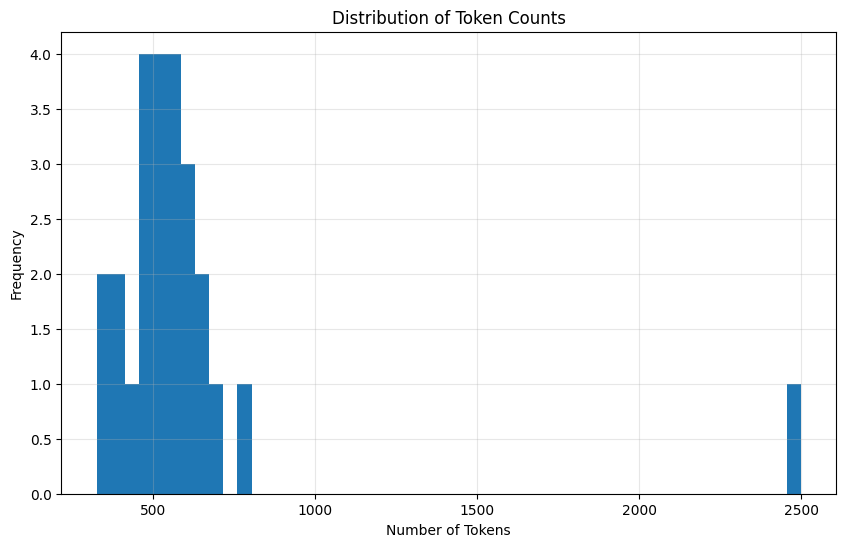

Average tokens per sample: 607.00
Minimum tokens: 325
Maximum tokens: 2500
Total tokens: 15,175


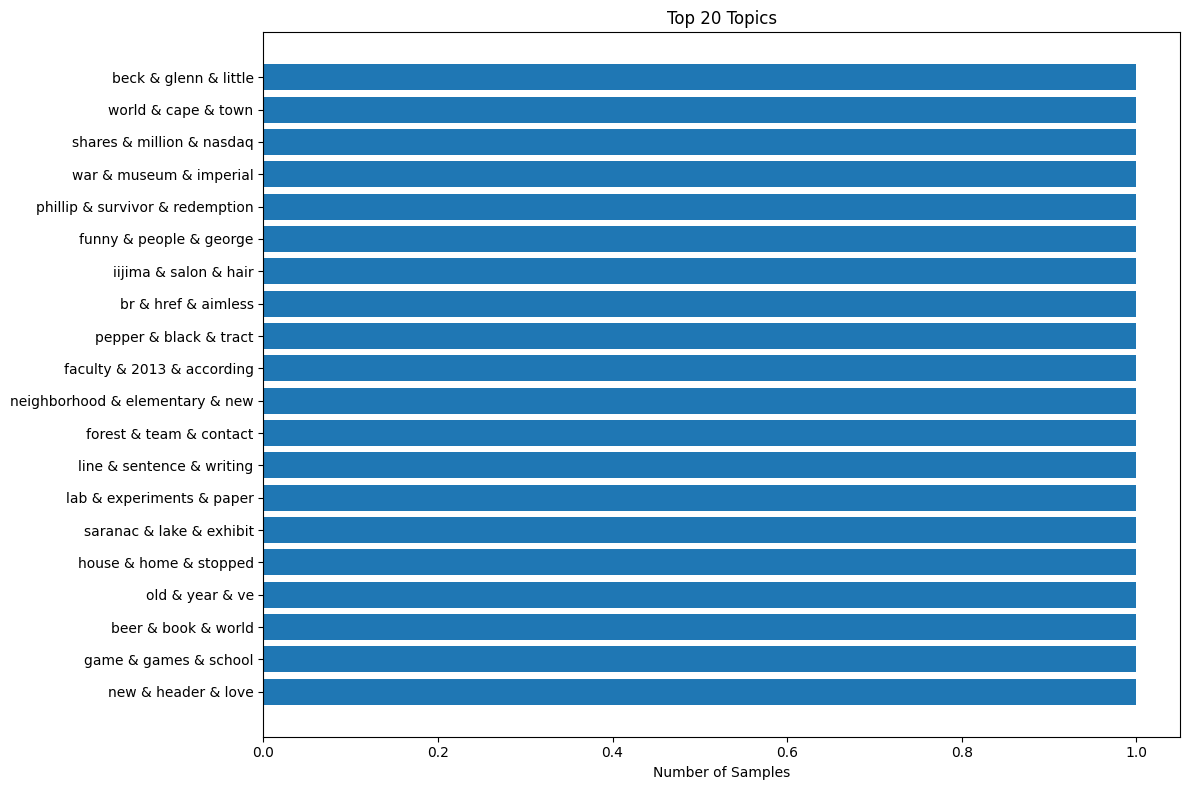

Total unique topics: 25
9. Saving final dataset...
Push dataset to small (uncomment code below to push to HF)
Workflow complete!


In [ ]:
run_complete_workflow(
    seed_dataset_name="tiiuae/falcon-refinedweb", 
    output_name="my-synthetic-dataset",
    sample_size=100,  # Using a small sample for demonstration
    num_to_generate=25
)